In [20]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

In [21]:
os.getcwd()

'd:\\Projects\\signature_verification\\dataset\\Utils'

## Reading image

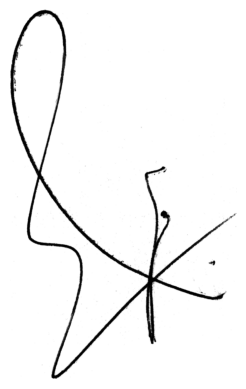

In [22]:
imag_path = os.path.join(os.getcwd(), "../Genuine/1/3.tif")
image = cv2.imread(imag_path)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.show()


## Resizing to max width of 600

In [23]:
def resize_max_length(image, max_length=600):
    height, width = image.shape[:2]
    longest_side = max(height, width)

    # If already smaller than or equal to max_length, return as is
    if longest_side <= max_length:
        return image

    # Calculate scale factor and new dimensions
    scale = max_length / longest_side
    new_width = int(width * scale)
    new_height = int(height * scale)

    resized = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_AREA)
    return resized

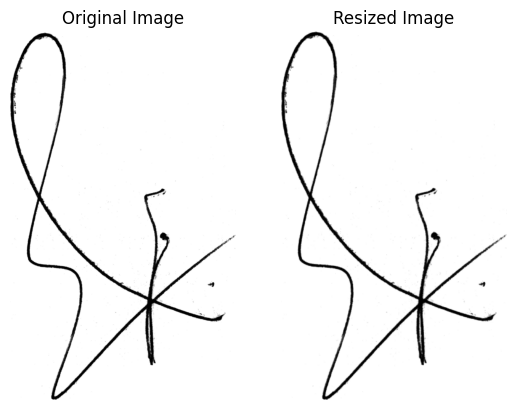

In [26]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')

plt.subplot(1,2,2)
resized_img = resize_max_length(image, max_length=600)
plt.imshow(resized_img)
plt.axis('off')  # Hide axes
plt.title('Resized Image')
plt.show()

## Applying median blur

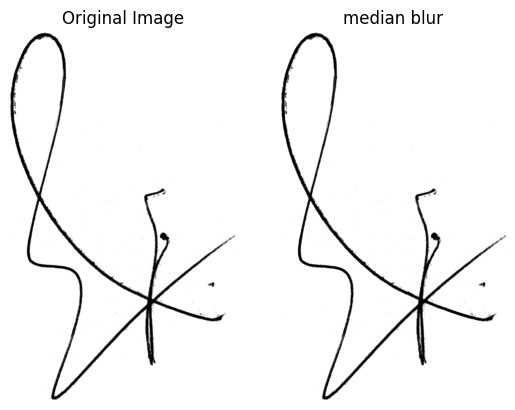

In [27]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')


plt.subplot(1,2,2)
# Apply median blur with 7x7 kernel
blurred = cv2.medianBlur(image, 7)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('median blur')
plt.show()

## grayscale conversion

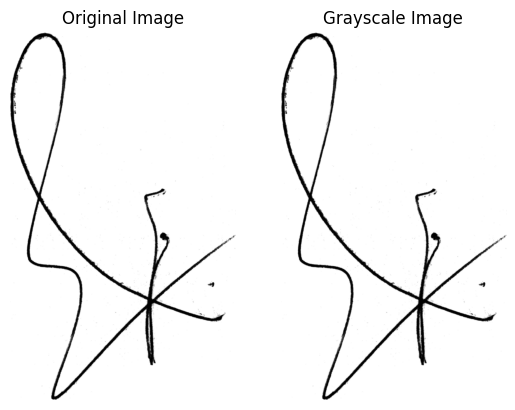

In [28]:
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')


plt.subplot(1,2,2)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')  # Hide axes
plt.title('Grayscale Image')
plt.show()

## Fast Non Local Mean denoising

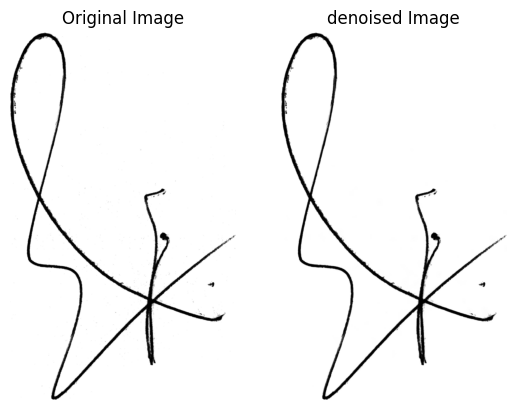

In [ ]:
denoised = cv2.fastNlMeansDenoising(
    src=gray,              # input image (must be grayscale)
    h=10,                  # filter strength (recommended: 3-10)
    templateWindowSize=10, # size of the template patch
    searchWindowSize=21    # size of the window to search for similar patches
)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(denoised, cmap='gray')
plt.axis('off')  # Hide axes    
plt.title('denoised Image')
plt.show()

## Image segmentation

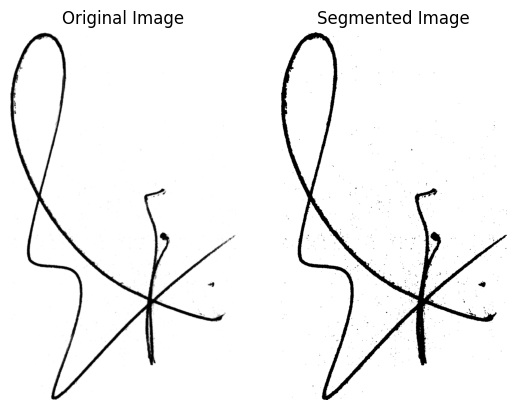

In [29]:
# Calculate average pixel value
threshold_value = int(np.mean(gray))

# Apply global thresholding on grayscale image
_, segmented = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(segmented, cmap='gray')
plt.title('Segmented Image')
plt.axis('off')  # Hide axes      
plt.show()   

## Image localization (Not useful)

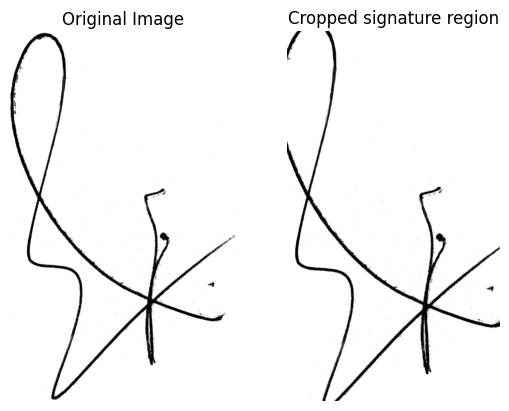

Signature region coordinates: (31, 33, 701, 1196)


In [ ]:
def get_projection_histogram(image, axis=0):
    # Sum pixel values across axis
    # axis=0: vertical projection (columns)
    # axis=1: horizontal projection (rows)
    return np.sum(image, axis=axis)


def find_boundaries(hist, length_side, thresh_length=30, decay_penalty=None):
    if decay_penalty is None:
        decay_penalty = length_side // 100

    count = 0
    boundary = 0

    for i in range(length_side):
        if count < 0:
            count = 0

        if hist[i] != 0:
            boundary = i
            count += 1
        else:
            count -= decay_penalty

        if count > thresh_length:
            break

    return boundary

def find_reverse_boundaries(hist, length_side, thresh_length=30, decay_penalty=None):
    if decay_penalty is None:
        decay_penalty = length_side // 100

    count = 0
    boundary = length_side

    for i in reversed(range(length_side)):
        if count < 0:
            count = 0

        if hist[i] != 0:
            boundary = i
            count += 1
        else:
            count -= decay_penalty

        if count > thresh_length:
            break

    return boundary

def crop_signature_region(image_path):
    # Load image and convert to grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Binarize the image (invert if needed)
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    height, width = binary.shape

    # Horizontal and vertical projections
    vertical_hist = get_projection_histogram(binary, axis=0)
    horizontal_hist = get_projection_histogram(binary, axis=1)

    # Get cropping coordinates
    left = find_boundaries(vertical_hist, width)
    right = find_reverse_boundaries(vertical_hist, width)
    top = find_boundaries(horizontal_hist, height)
    bottom = find_reverse_boundaries(horizontal_hist, height)

    # Crop image
    cropped = image[top:bottom, left:right]

    return cropped, (left, top, right, bottom)

# Example usage:
cropped_image, coords = crop_signature_region(imag_path)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cropped_image, cmap='gray')
plt.axis('off')  # Hide axes
plt.title('Cropped signature region')
plt.show()
print("Signature region coordinates:", coords)


## image padding

In [30]:
def pad_to_square(image):
    height, width = image.shape[:2]

    # Initialize padding
    leftPad = rightPad = topPad = bottomPad = 0

    # Determine padding needed
    if width < height:
        pad = (height - width) // 2
        leftPad = pad
        rightPad = height - width - pad  # to handle odd differences
    else:
        pad = (width - height) // 2
        topPad = pad
        bottomPad = width - height - pad

    # Apply padding (with white background = 255)
    color = [255, 255, 255] if len(image.shape) == 3 else 255
    padded_image = cv2.copyMakeBorder(
        image,
        top=topPad,
        bottom=bottomPad,
        left=leftPad,
        right=rightPad,
        borderType=cv2.BORDER_CONSTANT,
        value=color
    )

    return padded_image


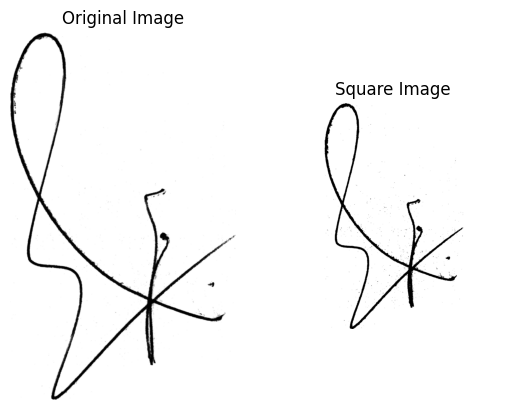

(1228, 753)
(1228, 1228)


In [32]:
# img = cv2.imread("cropped_signature.jpg", cv2.IMREAD_GRAYSCALE)
square_img = pad_to_square(segmented)
# cv2.imwrite("square_signature.jpg", square_img)

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(square_img, cmap='gray')
plt.axis('off')  # Hide axes
plt.title('Square Image')
plt.show()
print(gray.shape)
print(square_img.shape)

## final resizing

(1228, 1228)
(224, 224)


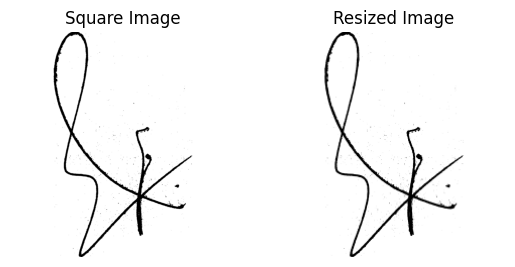

In [36]:
resized = cv2.resize(square_img, (224, 224), interpolation=cv2.INTER_AREA)
print(square_img.shape)
print(resized.shape) 

plt.subplot(1,2,1)
plt.imshow(square_img, cmap='gray')
plt.axis('off')  # Hide axes    
plt.title('Square Image')

plt.subplot(1,2,2)
plt.imshow(resized, cmap='gray')
plt.axis('off')  # Hide axes
plt.title('Resized Image')
plt.show()                          